# Role of Topology_Rumor Spreading

 topology of a network can greatly influence the dynamics of processes like rumor spreading. For instance, in a network where nodes are highly connected, rumors might spread faster than in a network where nodes are loosely connected.

Here, we will compare the dynamics of rumor spreading in the Barabasi-Albert network (G_BA) and the Erdos-Renyi (ER) network (G_ER) with the same degree distribution. Both networks have the same number of nodes and edges, but the connectivity structure is different.


In [1]:
import numpy as np
import random
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import collections

In [2]:
def rumor_network(G, l, alpha, status):
    """
    Perform a single step of the rumor spreading process.

    Arguments:
    - G: the network
    - l: the rate at which ignorants become spreaders
    - alpha: the rate at which spreaders become stiflers
    - status: a dictionary mapping nodes to their statuses ('I', 'S', or 'R')

    The status dictionary is modified in-place.
    """
    for node in G.nodes():
        if status[node] == 'S':  # if the node is a spreader
            for neighbor in G.neighbors(node):
                if status[neighbor] == 'I' and np.random.uniform(0,1) < l:
                    status[neighbor] = 'S'  # ignorant neighbor becomes a spreader
                elif status[neighbor] in ('S', 'R') and np.random.uniform(0,1) < alpha:
                    status[node] = 'R'  # spreader node becomes a stifler

def set_seeds(status, p):
    """
    Set a fraction p of nodes to be initial spreaders.

    Arguments:
    - status: a dictionary mapping nodes to their statuses ('I', 'S', or 'R')
    - p: the initial fraction of spreaders

    The status dictionary is modified in-place.
    """
    n_of_spreaders = int(p * len(status))  # number of nodes to make spreaders
    initial_spreaders = random.sample(status.keys(), n_of_spreaders)  # choose nodes randomly
    for node in initial_spreaders:
        status[node] = 'S'  # make selected nodes spreaders


### Comparision
Here we run the rumor spreading simulation on both a Barabasi-Albert network and an Erdos-Renyi network, then plots the number of spreaders and stiflers over time for both networks. We collect the status counts for each network at each time step, then plot the results using two subplots.

In [8]:
N = 10000  # number of nodes

# Create a Barabasi-Albert network with 100 nodes and 3 edges added for each new node
G_BA = nx.barabasi_albert_graph(N, 3)

# Create an Erdos-Renyi network with the same degree distribution
G_ER = nx.erdos_renyi_graph(N, 2. * G_BA.number_of_edges() / N**2)

# Initialize the status of each node to 'I' (ignorant) for both networks
status_BA = {node: 'I' for node in G_BA.nodes()}
status_ER = {node: 'I' for node in G_ER.nodes()}

# Set 10% of the nodes to be initial spreaders in both networks
set_seeds(status_BA, 0.1)
set_seeds(status_ER, 0.1)

# List to store counts over time for both networks
status_counts_over_time_BA = []
status_counts_over_time_ER = []

# Perform the rumor spreading process for a number of steps (time) in both networks
for _ in range(100):
    rumor_network(G_BA, l=0.1, alpha=0.1, status=status_BA)
    rumor_network(G_ER, l=0.1, alpha=0.1, status=status_ER)
    
    # Collect status counts
    status_counts_BA = collections.Counter(status_BA.values())
    status_counts_ER = collections.Counter(status_ER.values())
    
    status_counts_over_time_BA.append(status_counts_BA)
    status_counts_over_time_ER.append(status_counts_ER)


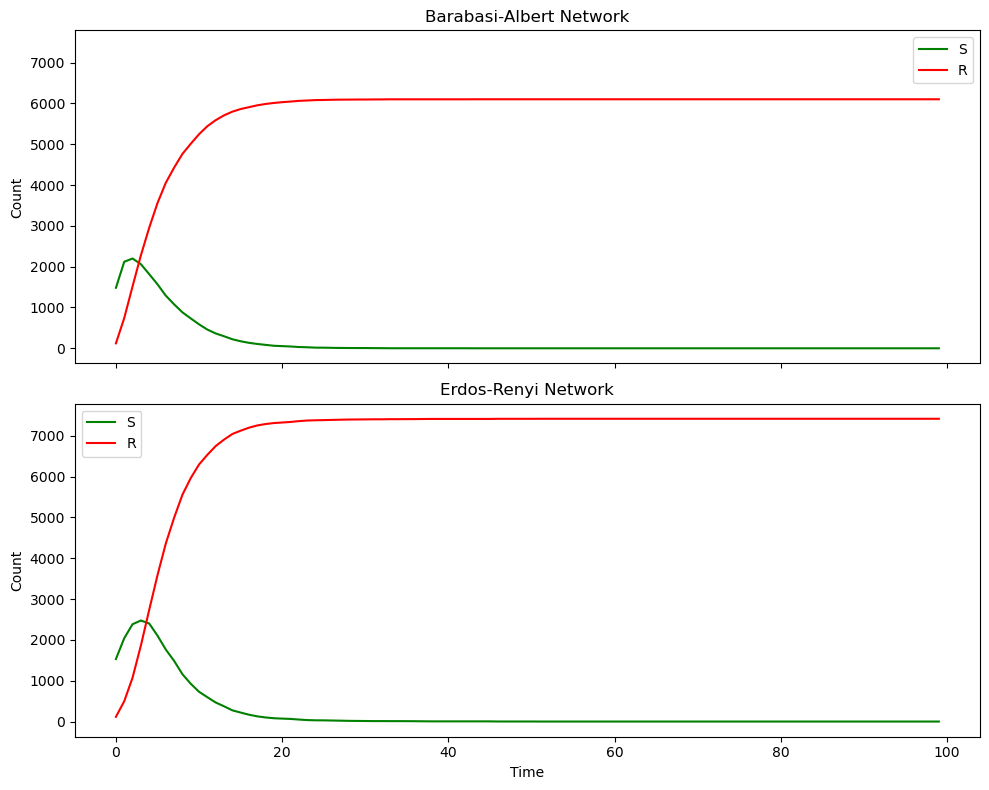

In [9]:
# Now let's plot the number of spreaders and stiflers over time for both networks
statuses = ['S', 'R']
colors = ['green', 'red']

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)

for status, color in zip(statuses, colors):
    ax[0].plot([counts.get(status, 0) for counts in status_counts_over_time_BA], color=color, label=status)
    ax[1].plot([counts.get(status, 0) for counts in status_counts_over_time_ER], color=color, label=status)

ax[0].set_title('Barabasi-Albert Network')
ax[1].set_title('Erdos-Renyi Network')
ax[0].legend()
ax[1].legend()

for a in ax:
    a.set_ylabel('Count')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

From above plot it might not be obvious the effect, lets create a two subplot figure where one subplot shows the number of spreaders (S) over time and the other subplot shows the number of stiflers (R) over time for both the Barabasi-Albert and Erdos-Renyi networks.

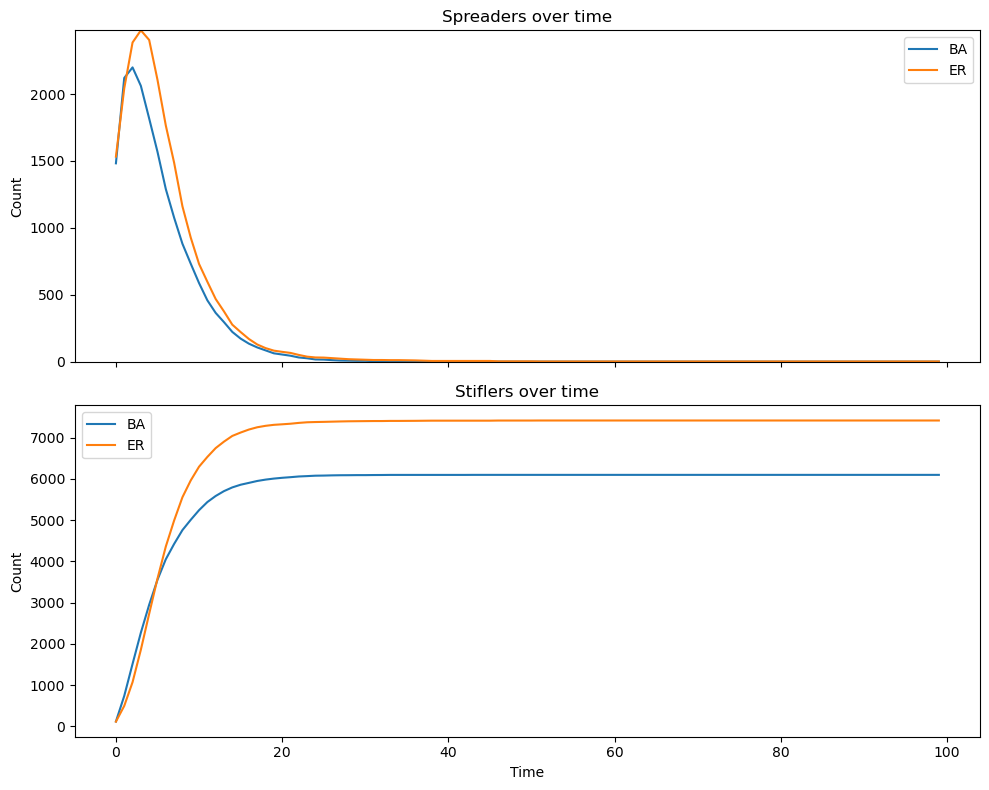

In [11]:
# Now let's plot the number of spreaders and stiflers over time for both networks
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Spreaders over time
ax[0].plot([counts.get('S', 0) for counts in status_counts_over_time_BA], label='BA')
ax[0].plot([counts.get('S', 0) for counts in status_counts_over_time_ER], label='ER')

# Adjust y-limit for spreaders
max_S = max(max([counts.get('S', 0) for counts in status_counts_over_time_BA]),
            max([counts.get('S', 0) for counts in status_counts_over_time_ER]))
ax[0].set_ylim(0, max_S)

# Stiflers over time
ax[1].plot([counts.get('R', 0) for counts in status_counts_over_time_BA], label='BA')
ax[1].plot([counts.get('R', 0) for counts in status_counts_over_time_ER], label='ER')

ax[0].set_title('Spreaders over time')
ax[1].set_title('Stiflers over time')

for a in ax:
    a.legend()
    a.set_ylabel('Count')

plt.xlabel('Time')
plt.tight_layout()
plt.show()


The above graphs depict the number of spreaders (S) and stiflers (R) over time for two different types of networks: Barabasi-Albert (BA) and Erdos-Renyi (ER). The Barabasi-Albert network is a scale-free network, meaning that its degree distribution follows a power law, i.e., there are a few nodes with a high degree (hubs) and many nodes with a low degree. On the other hand, the Erdos-Renyi network is a random network where each pair of nodes is connected with the same probability, resulting in a degree distribution that follows a binomial or Poisson distribution in the limit of large network sizes.



# Watts-Strogatz networks with varying "rewiring" probabilities (p)

Lets create a variety of Watts-Strogatz networks with varying "rewiring" probabilities (p). Then, lets run the rumor spreading model on each of these networks and observe the average time taken for the rumor to spread.

**rumor spread time** function: let's modify our rumor spreading function to return the time at which the number of spreaders peaks:

In [36]:
def rumor_spread_step(G, l, alpha, status):
    """
    Perform one step of the rumor spreading process.

    Arguments:
    - G: the network
    - l: the rumor spread probability
    - alpha: the stifling probability
    - status: a dictionary mapping nodes to their statuses ('I', 'S', or 'R')

    Returns: the updated status dictionary.
    """
    new_status = status.copy()

    for node in G.nodes():
        if status[node] == 'S':  # if the node is a spreader
            for neighbor in G.neighbors(node):
                if status[neighbor] == 'I' and random.uniform(0, 1) < l:  # if the neighbor is ignorant
                    new_status[neighbor] = 'S'  # the neighbor becomes a spreader
                elif status[neighbor] in ['S', 'R'] and random.uniform(0, 1) < alpha:  # if the neighbor is a spreader or stifler
                    new_status[node] = 'R'  # the node becomes a stifler

    return new_status


def set_seeds(status, p):
    """
    Set a fraction p of nodes to be initial spreaders.

    Arguments:
    - status: a dictionary mapping nodes to their statuses ('I', 'S', or 'R')
    - p: the initial fraction of spreaders

    The status dictionary is modified in-place.
    """
    n_of_spreaders = int(p * len(status))  # number of nodes to make spreaders
    initial_spreaders = random.sample(list(status.keys()), n_of_spreaders)  # choose nodes randomly
    for node in initial_spreaders:
        status[node] = 'S'  # make selected nodes spreaders



Lets generate the Watts-Strogatz graphs, run the rumor spread simulation on each of the graphs.

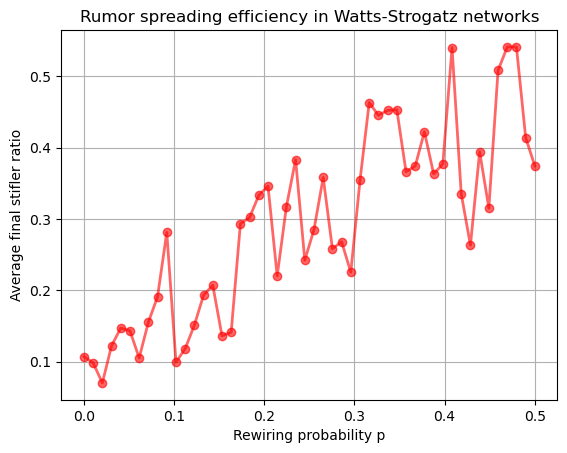

In [44]:
# Ensure rumor spread and stifling probabilities are set properly
l = 0.1  # rumor spread probability
alpha = 0.1  # stifling probability

# Create many WS graphs for different values of rewiring probability p
N = 100  # number of nodes
p_values = np.linspace(0, 0.5, 50)  # rewiring probabilities
graphs = [nx.watts_strogatz_graph(N, 4, p) for p in p_values]

# Initialize the array to store final stifler ratios
n_iterations = 10  # number of realizations for averaging
final_stifler_ratios = np.zeros((n_iterations, len(p_values)))

# Run the rumor spreading model on each network
for i, G in enumerate(graphs):
    for j in range(n_iterations):
        # Initialize all nodes as ignorants
        status = {node: 'I' for node in G.nodes()}

        # Set a fraction of nodes to be initial spreaders
        initial_spreaders = random.sample(G.nodes(), int(0.01 * N))
        for node in initial_spreaders:
            status[node] = 'S'

        # Simulate rumor spreading
        while 'S' in status.values():  # while there are any spreaders in the network
            status = rumor_spread_step(G, l, alpha, status)

        # Calculate the final stifler ratio
        stifler_ratio = list(status.values()).count('R') / N
        final_stifler_ratios[j, i] = stifler_ratio

# Calculate the average stifler ratio for each p
average_stifler_ratios = np.mean(final_stifler_ratios, axis=0)

# Plot the average stifler ratio as a function of p
plt.plot(p_values, average_stifler_ratios, 'o-', color='red', linewidth=2, alpha=0.6)
plt.xlabel('Rewiring probability p')
plt.ylabel('Average final stifler ratio')
plt.title('Rumor spreading efficiency in Watts-Strogatz networks')
plt.grid(True)
plt.show()
